## Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, boxcox


In [2]:
from ingest.catalog import DatasetCatalog
from ingest.loader import RawDatasetLoader
from ingest.fetch.csv import CsvAdapter
from ingest.fetch.sct import SocrataAdapter
from ingest.fetch.excel import ExcelAdapter
from ingest.fetch.metadata import SocrataMetadata

In [3]:
## servicios
catalog = DatasetCatalog()
loader = RawDatasetLoader(
    csv_adapter=CsvAdapter(),
    sct_adapter=SocrataAdapter(),
    excel_adapter=ExcelAdapter(),
)

## EDA

### Dataset Info

In [4]:
ds = catalog.get("empresas_10k")
meta = loader.metadata(ds)
if isinstance(meta, SocrataMetadata):
    print("Nombre:", meta.name)
    print("Descripción:", meta.description)
    print("Columnas:")
    columns = meta.columns
    for col in columns:
        print(f"  - {col.name} ({col.fieldName}): {col.dataTypeName}")
else:
    print("Este origen no soporta metadata estructurada.")

Nombre: 10.000 Empresas mas Grandes del País
Descripción: Reporte de las diez mil empresas más grandes del país, todas las cifras en este reporte se muestran en Billones de Pesos. Lo invitamos a participar en la siguiente encuesta https://forms.office.com/r/1cWttkdHqM
Columnas:
  - NIT (nit): number
  - RAZÓN SOCIAL (raz_n_social): text
  - SUPERVISOR (supervisor): text
  - REGIÓN (regi_n): text
  - DEPARTAMENTO DOMICILIO (departamento_domicilio): text
  - CIUDAD DOMICILIO (ciudad_domicilio): text
  - CIIU (ciiu): number
  - MACROSECTOR (macrosector): text
  - INGRESOS OPERACIONALES (ingresos_operacionales): text
  - GANANCIA (PÉRDIDA) (ganancia_p_rdida): text
  - TOTAL ACTIVOS (total_activos): text
  - TOTAL PASIVOS (total_pasivos): text
  - TOTAL PATRIMONIO (total_patrimonio): text
  - Año de Corte (a_o_de_corte): number


In [5]:
records = list(loader.load(ds))
df = pd.DataFrame(records)
df.head(3)

,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,$144.82,$33.41,$216.85,$125.81,$91.03,2022
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,$27.86,$2.19,$42.84,$16.48,$26.36,2022
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,$23.60,$0.33,$7.48,$4.47,$3.01,2022


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   nit                     40000 non-null  object
 1   raz_n_social            40000 non-null  object
 2   supervisor              40000 non-null  object
 3   regi_n                  40000 non-null  object
 4   departamento_domicilio  40000 non-null  object
 5   ciudad_domicilio        40000 non-null  object
 6   ciiu                    40000 non-null  object
 7   macrosector             40000 non-null  object
 8   ingresos_operacionales  40000 non-null  object
 9   ganancia_p_rdida        40000 non-null  object
 10  total_activos           40000 non-null  object
 11  total_pasivos           40000 non-null  object
 12  total_patrimonio        40000 non-null  object
 13  a_o_de_corte            40000 non-null  object
dtypes: object(14)
memory usage: 4.3+ MB


### Cleaning

In [7]:
df[df.isnull().any(axis=1)]

,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte


In [8]:
# Los únicos NaNs que hay son la Razón Social (el nombre) de dos empresas. No creo que merezca eliminar esas filas, solo le voy a poner el nombre de Faltante para identificarlas.
mask = df.raz_n_social.isnull()
faltantes = [f"Faltante{i+1}" for i in range(mask.sum())]
df.loc[mask, "raz_n_social"] = faltantes

In [9]:
cols = [
    "ingresos_operacionales",
    "ganancia_p_rdida",
    "total_activos",
    "total_pasivos",
    "total_patrimonio"
]

pretty_names = {
    col.fieldName: col.name
    for col in meta.columns
}

def pretty(col):
    return pretty_names.get(col, col)

# Convertir a número
for c in cols:
    df[c] = df[c].astype(str)\
                 .str.replace("$", "", regex=False)\
                 .str.replace(".", "", regex=False)\
                 .str.replace(",", ".", regex=False)\
                 .astype(float) 
    df[c] = pd.to_numeric(df[c], errors='coerce')


In [10]:
# miles de ceros y algunos valores negativos (perdidas) en varias variables
# outliers extremadamente grandes que generan colas largas
# mayor parte de las empresas se concentra en un rango mucho más pequeño.

for c in cols:
    print(pretty(c))
    print("Negativos:", (df[c] < 0).sum())
    print("Ceros:", (df[c] == 0).sum())
    print(df[c].describe())
    print()

INGRESOS OPERACIONALES
Negativos: 0
Ceros: 0
count    40000.000000
mean        16.766950
std        139.299075
min          1.000000
25%          3.000000
50%          4.000000
75%         10.000000
max      14482.000000
Name: ingresos_operacionales, dtype: float64

GANANCIA (PÉRDIDA)
Negativos: 1733
Ceros: 28200
count    40000.000000
mean         1.316000
std         25.404198
min       -321.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       3341.000000
Name: ganancia_p_rdida, dtype: float64

TOTAL ACTIVOS
Negativos: 0
Ceros: 1137
count    40000.000000
mean        21.806125
std        236.961751
min          0.000000
25%          2.000000
50%          3.000000
75%          9.000000
max      21685.000000
Name: total_activos, dtype: float64

TOTAL PASIVOS
Negativos: 0
Ceros: 6078
count    40000.000000
mean        11.070175
std        134.516182
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      13054.000000
Na

In [11]:
# se utiliza distibucion log-signed para visualizar mejor las distribuciones
def log_signed(x):
    return np.sign(x) * np.log1p(np.abs(x))
df_log_signed = df[cols].apply(log_signed)
df_log_pretty = df_log_signed.rename(columns=pretty)

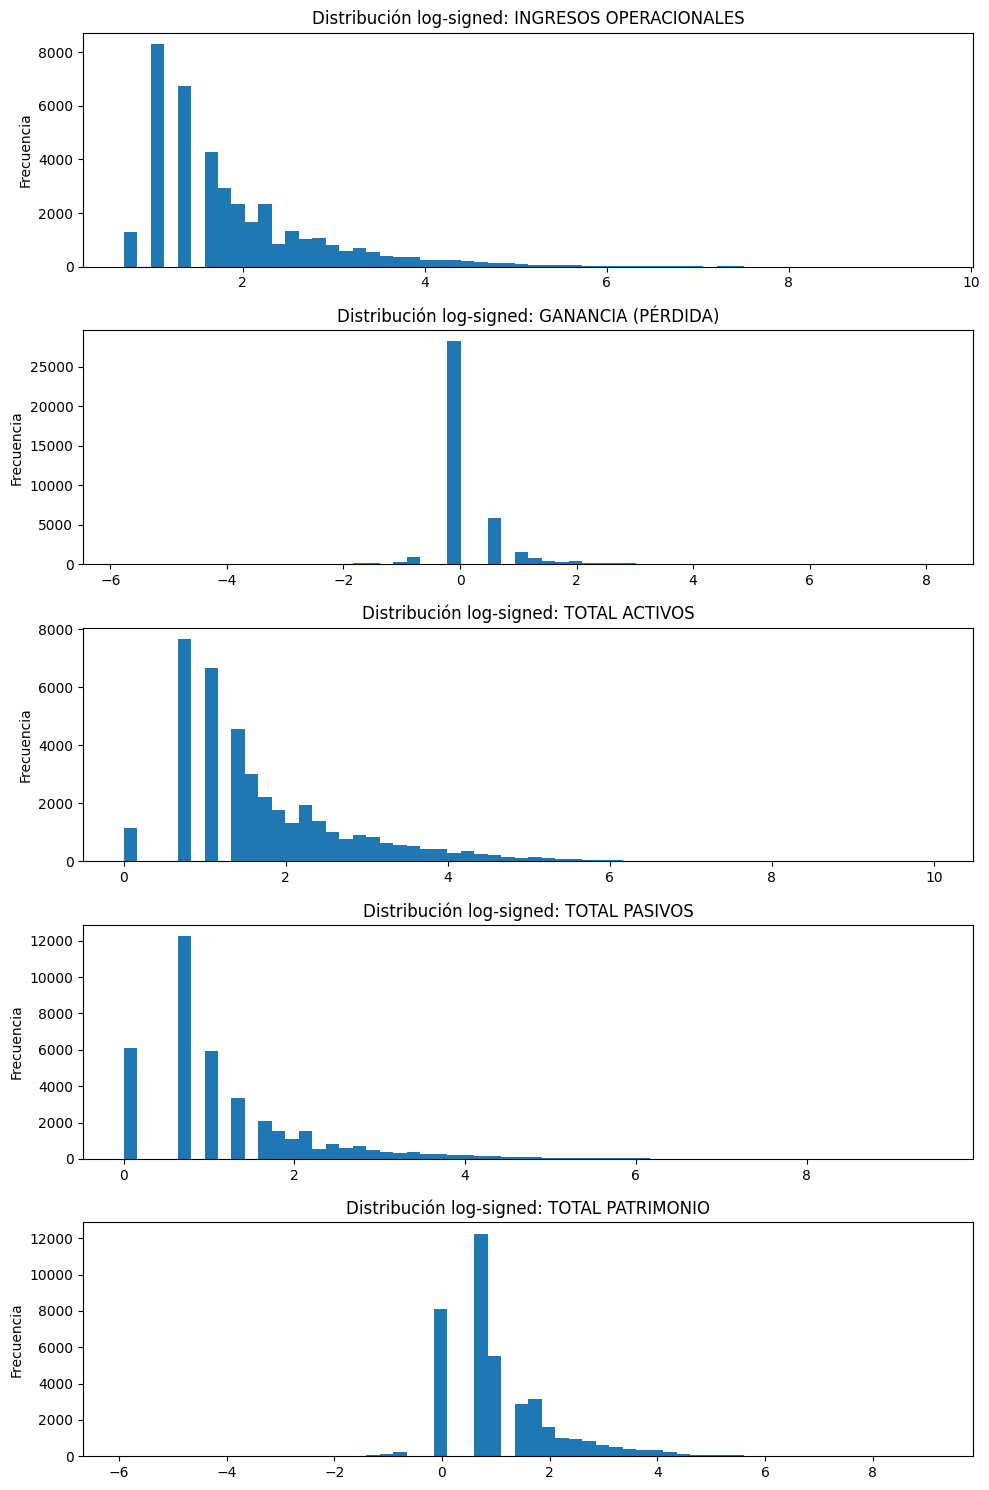

In [12]:
plt.figure(figsize=(10, 15))

for i, col in enumerate(df_log_pretty.columns, 1):
    transformed = df_log_pretty[col]

    plt.subplot(5, 1, i)
    plt.hist(transformed, bins=60)
    plt.title(f"Distribución log-signed: {col}")
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


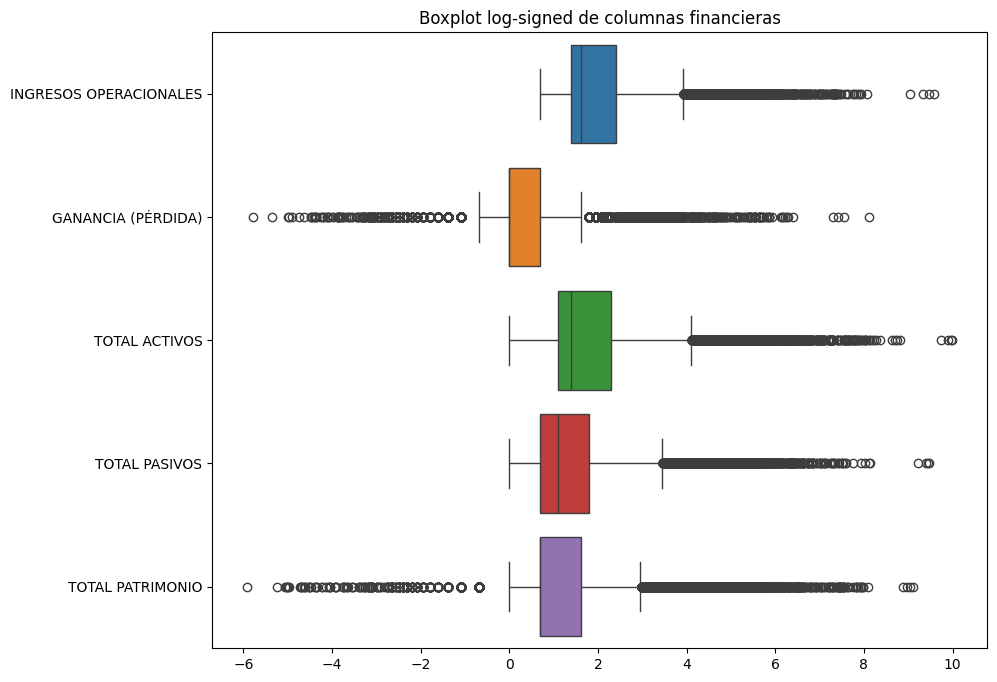

In [13]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_log_pretty, orient="h")
plt.title("Boxplot log-signed de columnas financieras")
plt.show()


In [14]:
df.head(3)

,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022


### Identificar Outliers

#### IQR

In [15]:
def detectar_outliers_iqr(df, cols):
    outliers_idx = set()
    for col in cols:
        if df[col].dropna().empty:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].index
        outliers_idx.update(outliers)
    return list(outliers_idx)

outlier_indices = detectar_outliers_iqr(df, cols)

df_outliers = df.loc[outlier_indices].copy()

print(f"Filas con outliers: {df_outliers.nit.unique().shape[0]} de {df.nit.unique().shape[0]} en todo el dataset -> = {df_outliers['nit'].unique().shape[0] / df['nit'].unique().shape[0] * 100:.2f}%")
df_outliers.head(3)


Filas con outliers: 3164 de 13976 en todo el dataset -> = 22.64%


,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022


#### El porcentaje es muy alto, intentemos normalizar primero los datos -> IQR VS KDE

- La asimetria puede ser natural? -> En modelos económicos se usa transformación, NO eliminación

In [16]:
cols_boxcox = []
for c in cols:
    min_val = df[c].min()
    shift = abs(min_val) + 1 if min_val <= 0 else 0
    transformed, lmbda = boxcox(df[c] + shift)
    new_col = c + "_boxcox"
    df[new_col] = transformed
    cols_boxcox.append(new_col)
    print(f"Columna: {c}, Lambda: {lmbda}")

def detectar_outliers_iqr(df, cols):
    outliers_idx = set()
    for col in cols:
        if df[col].dropna().empty:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 3 * IQR
        limite_superior = Q3 + 3 * IQR
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].index
        outliers_idx.update(outliers)
    return list(outliers_idx)

outlier_indices_boxcox = detectar_outliers_iqr(df, cols_boxcox)

df_outliers_boxcox = df.loc[outlier_indices_boxcox].copy()

print(f"Filas con outliers: {df_outliers_boxcox.nit.unique().shape[0]} de {df.nit.unique().shape[0]} en todo el dataset -> = {df_outliers_boxcox.nit.unique().shape[0] / df.nit.unique().shape[0] * 100:.2f}%")
df_outliers_boxcox.head(3)


Columna: ingresos_operacionales, Lambda: -0.3973021082593861
Columna: ganancia_p_rdida, Lambda: 0.1686523953806926
Columna: total_activos, Lambda: -0.4029060266741169
Columna: total_pasivos, Lambda: -0.4457929451851623
Columna: total_patrimonio, Lambda: -0.09546032417517186
Filas con outliers: 1606 de 13976 en todo el dataset -> = 11.49%


,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte,ingresos_operacionales_boxcox,ganancia_p_rdida_boxcox,total_activos_boxcox,total_pasivos_boxcox,total_patrimonio_boxcox
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022,2.461030,17.732953,2.437534,2.209834,6.104561
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022,2.409285,11.208945,2.396568,2.160656,5.598395
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022,2.401946,10.033464,2.309524,2.095642,4.847775


- Interpretación técnica:
    - Box-Cox logró “normalizar” los datos
    - Se redujo la cola derecha artificialmente
    - Ahora se detectan menos outliers porque la distribución original fue aplanada

- Interpretación económica:
    - Se esta escondiendo parte del comportamiento real del mercado

In [17]:
def detectar_outliers_kde(df, cols, quantile_thresh=0.01):
    outliers_idx = set()
    for col in cols:
        data = df[col].dropna().values
        if len(data) == 0:
            continue
        kde = gaussian_kde(data)
        densidades = kde(data)        
        threshold = np.quantile(densidades, quantile_thresh)
        outliers = df[col][densidades < threshold].index
        outliers_idx.update(outliers)
    return list(outliers_idx)

outlier_indices_kde = detectar_outliers_kde(df, cols, quantile_thresh=0.01)
df_outliers_kde = df.loc[outlier_indices_kde].copy()

In [18]:
total_outliers = df_outliers_kde.nit.unique().shape[0]
total_rows = df.nit.unique().shape[0]
print(f"Filas con outliers (KDE): {total_outliers} de {total_rows} en todo el dataset -> {total_outliers / total_rows * 100:.2f}%")
df_outliers_kde.head(3)

Filas con outliers (KDE): 315 de 13976 en todo el dataset -> 2.25%


,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte,ingresos_operacionales_boxcox,ganancia_p_rdida_boxcox,total_activos_boxcox,total_pasivos_boxcox,total_patrimonio_boxcox
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022,2.461030,17.732953,2.437534,2.209834,6.104561
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022,2.409285,11.208945,2.396568,2.160656,5.598395
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022,2.401946,10.033464,2.309524,2.095642,4.847775


- Interpretación (KDE)
    - Las distribuciones son muy asimétricas, con colas largas
    - El 2.25% detectado por KDE corresponde a empresas realmente grandes, no errores -> como podemos confirmarlo?
    - La mayoría de valores extremos son parte natural de la estructura empresarial
- Consideraciones
    - No eliminar los outliers KDE: son empresas clave.
    - Mantenerlos para modelos de crecimiento y dinámica sectorial.
    - Usar KDE solo para interpretar dispersión, no para filtrar datos.

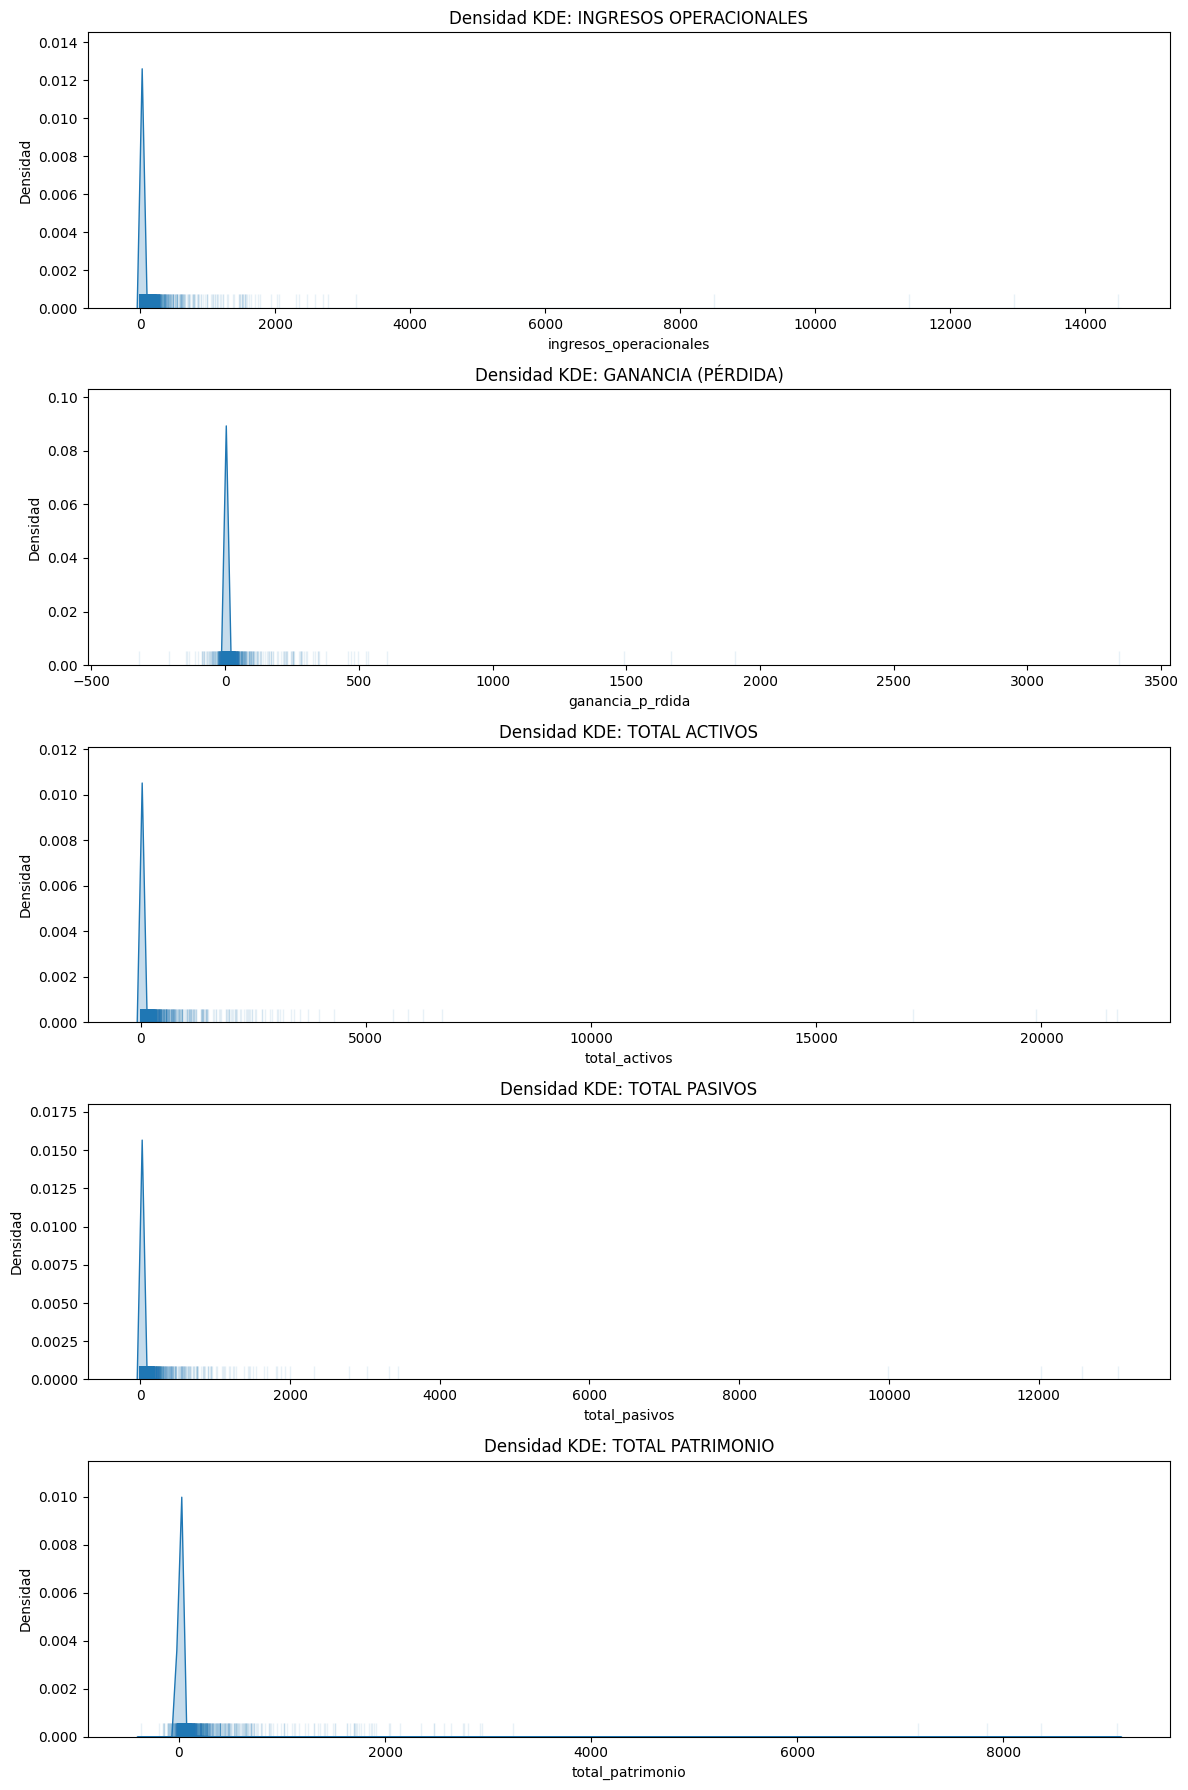

In [19]:
plt.figure(figsize=(12, 18))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    sns.kdeplot(df[col], fill=True, bw_adjust=1.0)
    sns.rugplot(df[col], height=0.05, alpha=0.1)
    plt.title(f"Densidad KDE: {pretty(col)}")
    plt.ylabel("Densidad")

plt.tight_layout()
plt.show()

#### Probamos KDE en lugar de IQR


In [20]:
cols_boxcox = []
for c in cols:
    min_val = df[c].min()
    shift = abs(min_val) + 1 if min_val <= 0 else 0
    transformed, lmbda = boxcox(df[c] + shift)
    new_col = c + "_boxcox"
    df[new_col] = transformed
    cols_boxcox.append(new_col)
    print(f"Columna: {c}, Lambda: {lmbda:.4f}, Shift aplicado: {shift}")

# Detectar outliers usando KDE sobre los datos Box-Cox
def detectar_outliers_kde(df, cols, quantile_thresh=0.01):
    outliers_idx = set()
    for col in cols:
        data = df[col].dropna().values
        if len(data) == 0:
            continue
        kde = gaussian_kde(data)
        densidades = kde(data)
        
        # Consideramos outliers los puntos con densidad muy baja
        threshold = np.quantile(densidades, quantile_thresh)
        outliers = df[col][densidades < threshold].index
        outliers_idx.update(outliers)
    return list(outliers_idx)

# Detectar outliers en todo el DataFrame usando columnas Box-Cox
outlier_indices = detectar_outliers_kde(df, cols_boxcox, quantile_thresh=0.01)
df_outliers = df.loc[outlier_indices].copy()

Columna: ingresos_operacionales, Lambda: -0.3973, Shift aplicado: 0
Columna: ganancia_p_rdida, Lambda: 0.1687, Shift aplicado: 322.0
Columna: total_activos, Lambda: -0.4029, Shift aplicado: 1.0
Columna: total_pasivos, Lambda: -0.4458, Shift aplicado: 1.0
Columna: total_patrimonio, Lambda: -0.0955, Shift aplicado: 370.0


In [21]:
total_outliers = df_outliers.nit.unique().shape[0]
total_rows = df.nit.unique().shape[0]
print(f"Filas con outliers detectados: {total_outliers} de {total_rows} ({total_outliers / total_rows * 100:.2f}%)")
df_outliers.head(3)

Filas con outliers detectados: 324 de 13976 (2.32%)


,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte,ingresos_operacionales_boxcox,ganancia_p_rdida_boxcox,total_activos_boxcox,total_pasivos_boxcox,total_patrimonio_boxcox
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022,2.461030,17.732953,2.437534,2.209834,6.104561
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022,2.409285,11.208945,2.396568,2.160656,5.598395
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022,2.401946,10.033464,2.309524,2.095642,4.847775


- Interpretacion
    - Box-Cox suaviza las colas largas y reduce la asimetría, pero no elimina la naturaleza economica de los valores grandes
    - KDE identifica outliers según baja densidad, no según tamaño; es más estable que IQR
    - El método detectó 2.32% de empresas como outliers, muy similar al 2.25% con KDE original, lo que confirma que los outliers son casos reales y consistentes
    - Las empresas marcadas corresponden a grandes compañías -> (Ecopetrol, Reficar, Terpel, Cerrejón, Drummond)
    - No hay evidencia de datos sucios, son outliers legítimos por tamaño económico
    - No existe riesgo estadístico en usar Box-Cox + KDE, pero sí habría riesgo en eliminar esos puntos
    - Box-Cox + KDE debe usarse para análisis, no para filtrado; eliminar estos valores podría distorsionar la estructura real del mercado

#### KDE pero aplicado a cada MACROSECTOR y año

In [22]:
cols_boxcox = []
for c in cols:
    min_val = df[c].min()
    shift = abs(min_val) + 1 if min_val <= 0 else 0
    transformed, lmbda = boxcox(df[c] + shift)
    new_col = c + "_boxcox"
    df[new_col] = transformed
    cols_boxcox.append(new_col)
    print(f"Columna: {c}, Lambda: {lmbda:.4f}, Shift aplicado: {shift}")

# Función para detectar outliers usando KDE
def detectar_outliers_kde(df, cols, quantile_thresh=0.01):
    outliers_idx = set()
    for col in cols:
        data = df[col].dropna().values
        if len(data) == 0:
            continue
        kde = gaussian_kde(data)
        densidades = kde(data)
        
        # Consideramos outliers los puntos con densidad muy baja
        threshold = np.quantile(densidades, quantile_thresh)
        outliers = df[col][densidades < threshold].index
        outliers_idx.update(outliers)
    return list(outliers_idx)

# Detectar outliers por MACROSECTOR y Año de Corte
outlier_indices = set()
for sector in df.macrosector.unique():
    for año in df.a_o_de_corte.unique():
        df_seg = df[(df.macrosector == sector) & (df.a_o_de_corte == año)]
        if not df_seg.empty:
            idx = detectar_outliers_kde(df_seg, cols_boxcox, quantile_thresh=0.01)
            outlier_indices.update(idx)

df_outliers = df.loc[list(outlier_indices)].copy()
total_outliers = df_outliers.nit.unique().shape[0]
total_rows = df.nit.unique().shape[0]
print(f"Filas con outliers detectados por MACROSECTOR y Año: {total_outliers} de {total_rows} ({total_outliers / total_rows * 100:.2f}%)")
df_outliers.head(3)

Columna: ingresos_operacionales, Lambda: -0.3973, Shift aplicado: 0
Columna: ganancia_p_rdida, Lambda: 0.1687, Shift aplicado: 322.0
Columna: total_activos, Lambda: -0.4029, Shift aplicado: 1.0
Columna: total_pasivos, Lambda: -0.4458, Shift aplicado: 1.0
Columna: total_patrimonio, Lambda: -0.0955, Shift aplicado: 370.0
Filas con outliers detectados por MACROSECTOR y Año: 413 de 13976 (2.96%)


,nit,raz_n_social,supervisor,regi_n,departamento_domicilio,ciudad_domicilio,ciiu,macrosector,ingresos_operacionales,ganancia_p_rdida,total_activos,total_pasivos,total_patrimonio,a_o_de_corte,ingresos_operacionales_boxcox,ganancia_p_rdida_boxcox,total_activos_boxcox,total_pasivos_boxcox,total_patrimonio_boxcox
0,899999068,ECOPETROL S.A,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,610,MINERO,14482.0,3341.0,21685.0,12581.0,9103.0,2022,2.461030,17.732953,2.437534,2.209834,6.104561
1,900112515,REFINERIA DE CARTAGENA S.A.S,SUPERSOCIEDADES,Costa Atlántica,BOLIVAR,CARTAGENA-BOLIVAR,1921,MANUFACTURA,2786.0,219.0,4284.0,1648.0,2636.0,2022,2.409285,11.208945,2.396568,2.160656,5.598395
2,830095213,ORGANIZACIÓN TERPEL S.A.,SUPERFINANCIERA,Bogotá - Cundinamarca,BOGOTA D.C.,BOGOTA D.C.-BOGOTA D.C.,4661,COMERCIO,2360.0,33.0,748.0,447.0,301.0,2022,2.401946,10.033464,2.309524,2.095642,4.847775


- Interpretación
    - porcentaje de outliers sectoriales muy bajo (2.96%), puede indicar la mayoría de empresas se comportan como sus pares
    - las empresas marcadas son las más grandes y dominantes de cada sector, no errores

In [23]:
# df = df.drop(index=list(outlier_indices)).copy()
# df

## Summary

- Las pruebas de outliers (IQR, KDE y KDE por sector-año) muestran que los valores extremos corresponden a empresas grandes y estructurales
- Se va a ingerir todos los registros -> los outliers contienen señal económica util para el modelo y la construcción del dominio
- Para análisis y modelado investigar transformaciones -> log-signed, Box-Cox y RobustScaler, sin eliminar observaciones
- Experimentos descriptivos útiles: KDE por sector, boxplots log-scaled, rank-size (Pareto) y participación del top-1%/10%
- Con esta validación se puede avanzar a definir el primer dominio y las features base del pipeline: ingresos, activos, pasivos, patrimonio, margen y tasas de crecimiento por empresa y sector